In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
%matplotlib inline 
import scipy.special

Note: I simulate the SIR epidemic spreading process using degree infectivity, i.e., during a time step, an infectious node will attempt to infect all of its neighbors.

First, define functions for I-R and S-I processes of SIR:

In [36]:
def recover(i_nodes, r_nodes, p):
    """ Given list of infected nodes, recovered nodes, and IR transition probability, 
    recovers some infected nodes at random according to p
    Returns list of infected nodes and recovered nodes """
    no_infected = len(i_nodes)
    if no_infected == 0:
        return i_nodes, r_nodes
    
    randoms = [random.random() for i in range(no_infected)]
    
    # List of Boolean values for whether the corresponding infected node recovers
    recover = [x<p for x in randoms]
    
    # Apply Booleans as filter with np arrays 
    I_array = np.asarray(i_nodes)
    filter = np.array(recover)
    new_recovered_nodes = I_array[filter] # np array of infected nodes that are now recovered
    new_recovered_nodes = list(new_recovered_nodes) # cast as list
    
    # Remove these newly recovered nodes from the infected nodes
    i_nodes = [item for item in i_nodes if item not in new_recovered_nodes]
    
    r_nodes += new_recovered_nodes
    
    return i_nodes, r_nodes 

def spread(G, s_nodes, i_nodes, p):
    """"for each node in the I state, the node has probability p of passing disease to neighbors who are in S state
    Returns list of new s nodes and new i nodes 
    """
    
    for node_id in i_nodes:
        # find neighbors in the S state
        neighbors_in_s = list(set(G.neighbors(node_id)) & set(s_nodes))
        
        if len(neighbors_in_s) == 0: #If that node has no neighbors in S state, skip to next node
            continue
        
        randoms = [random.random() for i in range(len(neighbors_in_s))]
        
        # List of booleans for whether or not the neighbor in S state gets infected
        infected = [x<p for x in randoms]
        
        # Apply boolean as filter to get the neighbor S nodes that get infected.
        neighbors_s_array = np.asarray(neighbors_in_s)
        filter = np.array(infected)
        
        new_infected_nodes = neighbors_s_array[filter] # np array of now-infected nodes
        new_infected_nodes = list(new_infected_nodes) # cast as list
        
        # remove these new infected nodes from s_nodes
        s_nodes = [item for item in s_nodes if item not in new_infected_nodes]
        
        # Append new infected nodes to i_nodes list
        i_nodes += new_infected_nodes
    
    return s_nodes, i_nodes

Next, define functions for a node calculating its perceived probability of infection, which it uses for its vaccination decision making.

In [3]:
def prob_of_disease(G, node, vaccinated_neighbors, p_si):
    """G: networkx graph
        node: node id for graph
        vaccinated_neighbors: integer"""

    """Returns probability of disease given x many vacc. 1st degree neighbors """
    
    p_vacc = vaccinated_neighbors/G.degree(node)
    
    p_infection = 0
    for i in range(G.degree(node)):
        p_infection+= scipy.special.binom(G.degree(node), i)*p_vacc**i*(1-p_vacc)**(G.degree(node)-i)*(1-(1-p_si)**(G.degree(node)-i))
        
    return p_infection

def vaccinate_decision_making(G, s_nodes, v_nodes, thresholds, p_si):
    """Given information, some susceptible nodes decide to vaccinate """
    """Suppose we give information about how many first degree neighbors have vaccinated"""
    
    # Each susceptible node calculates probability of contracting disease
    for node in s_nodes:
        vaccinated_neighbors = len(list(set(G.neighbors(node)) & set(v_nodes)))
    
        p_disease = prob_of_disease(G, node, vaccinated_neighbors, p_si)
        if p_disease > thresholds[node]: #If probability greater than threshold, vaccinate
            v_nodes.append(node)
            
    s_nodes = [node for node in s_nodes if node not in v_nodes]
    return s_nodes, v_nodes
    

In [14]:
def simulate_main(G, p_si, p_ir, num_infected_init, num_vaccinate_init, thresholds):
    '''Simulates the public health intervention in which we give each node information about
    the vacination status of its 1st degree neighbors. Terminates when all infected nodes have recovered'''
    
    v_nodes = list(np.random.choice(G.nodes(), num_vaccinate_init, replace=False)) # Initialize vaccinated nodes 
    init_susceptible = list(set(G.nodes()) - set(v_nodes)) #Initially susceptible cannot be a vaccinated node
    
    # initialize nodes
    i_nodes = list(np.random.choice(init_susceptible, num_infected_init, replace=False)) # choose initially infected nodes. Cannot be an effectively vaccinated node.
    s_nodes = [node for node in init_susceptible if node not in i_nodes] # susceptible nodes are not infected and not vaccinatd
    r_nodes = [] # recovered AFTER getting infection 
    
    # initialize lengths
    num_s_nodes = [len(s_nodes)]
    num_i_nodes = [len(i_nodes)]
    num_r_nodes = [len(r_nodes)]
    num_v_nodes = [len(v_nodes)]

    # initialize counter of time steps, for plotting individual simulations    
    num_time_steps = 1 #already did one time step with initialization
    
    while len(i_nodes) > 0: # run simulation while there are still infected nodes
        # PART A: Vaccination decision 
        s_nodes, v_nodes = vaccinate_decision_making(G, s_nodes, v_nodes, thresholds, p_si)
        
        # PART B: SIR SPREAD 
        # I to R transition step for one time step
        i_nodes, r_nodes = recover(i_nodes, r_nodes, p_ir)
        
        # simulate S to I spread
        s_nodes, i_nodes = spread(G, s_nodes, i_nodes, p_si)

        # Update lengths
        num_s_nodes.append(len(s_nodes))
        num_i_nodes.append(len(i_nodes))
        num_r_nodes.append(len(r_nodes))
        num_v_nodes.append(len(v_nodes))
        
        num_time_steps += 1
        
    return num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps 

In [101]:
p_si = 0.5
p_ir = 0.1

**BA graph, public health intervention**

In [72]:
proportions_vaccinated = []
proportions_infected = []

n = 100
num_infected_init = np.int(n/5)
num_vaccinate_init = np.int(n/5)

for i in range(1000):
    vaccinate_threshold = [0.5 for i in range(n)] # Using uniform thresholds 
    G = nx.barabasi_albert_graph(n,2,seed=1)
    num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_main(G, p_si, p_ir, num_infected_init, num_vaccinate_init, thresholds = vaccinate_threshold)
    proportions_vaccinated.append(num_v_nodes[-1]/n)
    proportions_infected.append(num_r_nodes[-1]/n) 
    
    # plt.plot(range(num_time_steps), num_s_nodes)
    # plt.plot(range(num_time_steps), num_i_nodes)
    # plt.plot(range(num_time_steps), num_r_nodes)
    # plt.plot(range(num_time_steps), num_v_nodes)
    # plt.show()

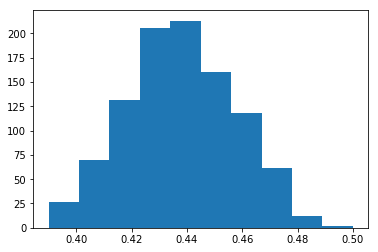

In [81]:
plt.hist(proportions_vaccinated)
plt.show()

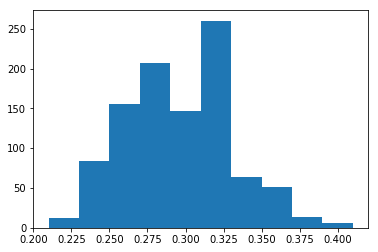

In [74]:
plt.hist(proportions_infected)
plt.show()

**Complete graph, public health intervention**

In [75]:
proportions_vaccinated = []
proportions_infected = []
for i in range(1000):
    n = 100
    G_complete = nx.complete_graph(n)
    thresholds = [0.5 for i in range(n)]
    num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_main(G_complete, p_si, p_ir, num_infected_init, num_vaccinate_init, thresholds)
    proportions_vaccinated.append(num_v_nodes[-1]/n)
    proportions_infected.append(num_r_nodes[-1]/n) 

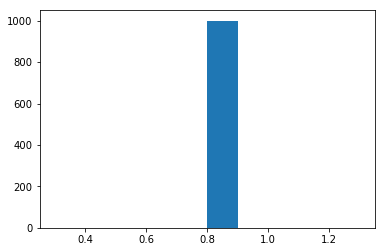

In [76]:
plt.hist(proportions_vaccinated)
plt.show()

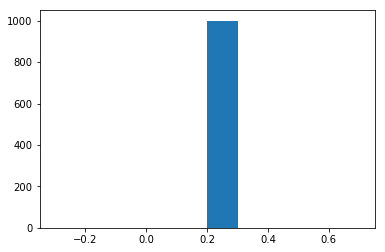

In [77]:
plt.hist(proportions_infected)
plt.show()

**Cycle graph, public health intervention**

In [78]:
proportions_vaccinated = []
proportions_infected = []
for i in range(1000):
    n = 100
    G_complete = nx.cycle_graph(n)
    thresholds = [0.5 for i in range(n)]
    num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_main(G_complete, p_si, p_ir, num_infected_init, num_vaccinate_init, thresholds)
    proportions_vaccinated.append(num_v_nodes[-1]/n)
    proportions_infected.append(num_r_nodes[-1]/n) 

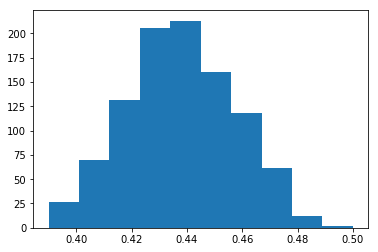

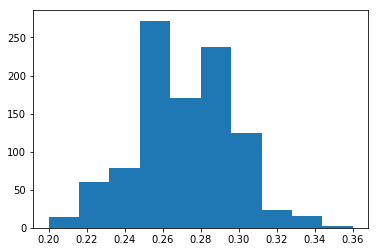

In [79]:
plt.hist(proportions_vaccinated)
plt.show()
plt.hist(proportions_infected)
plt.show()

###  Now, model the case where there is no public helath intervention, and instead, individuals randomly decide to vaccinate. 

In [95]:
def vaccinate_randomly(p_vacc, v_nodes, s_nodes):
    randoms = [random.random() for i in range(len(s_nodes))]
    
    vaccinate = [x < p_vacc for x in randoms]
    s_nodes_array = np.array(s_nodes)
    new_vaccinated_nodes = s_nodes_array[vaccinate]
    new_vaccinated_nodes = list(new_vaccinated_nodes)
    
    v_nodes += new_vaccinated_nodes 
    s_nodes = [item for item in s_nodes if item not in new_vaccinated_nodes]
    
    return s_nodes, v_nodes 

In [83]:
def simulate_sir(G, p_si, p_ir, num_infected_init, num_vaccinate_init, thresholds):
    '''Simulates all'''
    v_nodes = list(np.random.choice(G.nodes(), num_vaccinate_init, replace=False)) # Initialize vaccinated nodes 
    init_susceptible = list(set(G.nodes()) - set(v_nodes)) #Initially susceptible cannot be a vaccinated node
    
    # initialize nodes
    i_nodes = list(np.random.choice(init_susceptible, num_infected_init, replace=False)) # choose initially infected nodes. Cannot be an effectively vaccinated node.
    s_nodes = [node for node in init_susceptible if node not in i_nodes] # susceptible nodes are not infected and not vaccinatd
    r_nodes = [] # recovered AFTER getting infection 
        
    # initialize lengths
    num_s_nodes = [len(s_nodes)]
    num_i_nodes = [len(i_nodes)]
    num_r_nodes = [len(r_nodes)]
    num_v_nodes = [len(v_nodes)]

    
    # initialize counter of time steps
    # need this to set xlim on plot later
    num_time_steps = 1 #already did one time step with initialization
    

    while len(i_nodes) > 0: # run simulation while there are still infected nodes
        # PART A: Vaccination decision 
        s_nodes, v_nodes = vaccinate_randomly(0.2, v_nodes, s_nodes)
        
        # PART B: SIR SPREAD 
        # I to R transition step for one time step
        i_nodes, r_nodes = recover(i_nodes, r_nodes, p_ir)
        
        # simulate S to I spread
        s_nodes, i_nodes = spread(G, s_nodes, i_nodes, p_si)

        # Update lengths
        num_s_nodes.append(len(s_nodes))
        num_i_nodes.append(len(i_nodes))
        num_r_nodes.append(len(r_nodes))
        num_v_nodes.append(len(v_nodes))
        
        num_time_steps += 1
        
    return num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps 

**BA graph, no public health intervention**

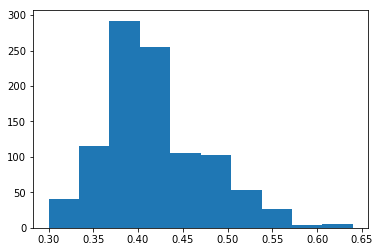

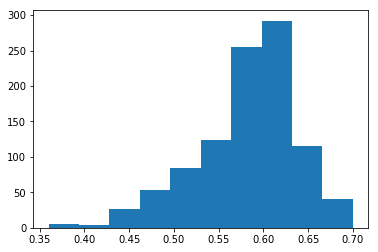

In [100]:
proportions_vaccinated = []
proportions_infected = []

n = 100
num_infected_init = np.int(n/5)
num_vaccinate_init = np.int(n/5)

for i in range(1000):
    vaccinate_threshold = [0.5 for i in range(n)]
    G = nx.barabasi_albert_graph(n,2,seed=1)
    num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_sir(G, p_si, p_ir, num_infected_init, num_vaccinate_init, thresholds = vaccinate_threshold)
    proportions_vaccinated.append(num_v_nodes[-1]/n)
    proportions_infected.append(num_r_nodes[-1]/n) 
plt.hist(proportions_vaccinated)
plt.show()
plt.hist(proportions_infected)
plt.show()

**Complete graph, no public health intervention**

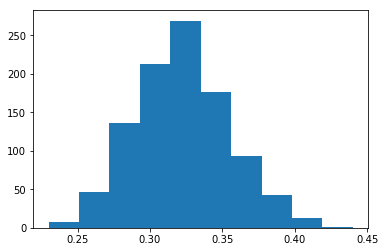

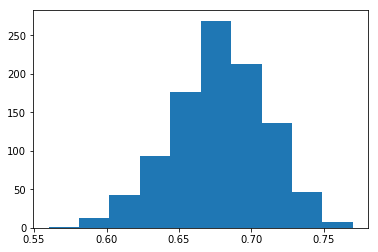

In [98]:
proportions_vaccinated = []
proportions_infected = []

n = 100
num_infected_init = np.int(n/5)
num_vaccinate_init = np.int(n/5)

for i in range(1000):
    vaccinate_threshold = [0.5 for i in range(n)]
    G = nx.complete_graph(n)
    num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_sir(G, p_si, p_ir, num_infected_init, num_vaccinate_init, thresholds = vaccinate_threshold)
    proportions_vaccinated.append(num_v_nodes[-1]/n)
    proportions_infected.append(num_r_nodes[-1]/n) 
plt.hist(proportions_vaccinated)
plt.show()
plt.hist(proportions_infected)
plt.show()

**Cycle graph, no public health intervention**

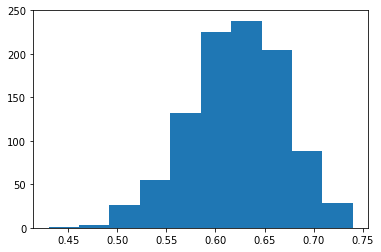

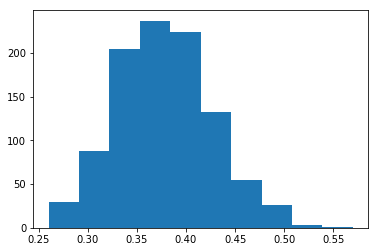

In [99]:
proportions_vaccinated = []
proportions_infected = []

n = 100
num_infected_init = np.int(n/5)
num_vaccinate_init = np.int(n/5)

for i in range(1000):
    vaccinate_threshold = [0.5 for i in range(n)]
    G = nx.cycle_graph(n)
    num_s_nodes, num_i_nodes, num_r_nodes, num_v_nodes, num_time_steps = simulate_sir(G, p_si, p_ir, num_infected_init, num_vaccinate_init, thresholds = vaccinate_threshold)
    proportions_vaccinated.append(num_v_nodes[-1]/n)
    proportions_infected.append(num_r_nodes[-1]/n) 
plt.hist(proportions_vaccinated)
plt.show()
plt.hist(proportions_infected)
plt.show()